In [1]:
%matplotlib inline

from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Input
from tensorflow.keras.losses import BinaryCrossentropy

#JIT for the data generation.
from numba import jit

from IPython import display

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Data Gen

In [2]:
@jit
def Kernel(x, x0):
    sigma = 0.8
    protonFraction = 0.4
    norm = protonFraction/(np.sqrt(2.*np.pi)*sigma)
    return(norm*np.exp(-(x - x0)**2./(2.*sigma**2.)))

@jit
def FakeKernel(x, x0, s):
    sigma = s
    protonFraction = 0.4
    norm = protonFraction/(np.sqrt(2.*np.pi)*sigma)
    return(norm*np.exp(-(x - x0)**2./(2.*sigma**2.)))

In [3]:
@jit
def test_data_gen(fakeKernel=False, sigma=0.4):
    A = 197
    yBeam = 5.36
    slope = 0.5
    sigmaEtas = 0.2
    
    # generate input data
    nBaryons = np.random.randint(0, 2*A)
    randX = np.random.uniform(0, 1, size=nBaryons)
    etasBaryon = 1./slope*np.arcsinh((2.*randX - 1)*np.sinh(slope*yBeam))
    etasArr = np.linspace(-6.4, 6.4, 128)
    dNBdetas = np.zeros(len(etasArr))
    norm = 1./(np.sqrt(2.*np.pi)*sigmaEtas)
    for iB in etasBaryon:
        dNBdetas += norm*np.exp(-(etasArr - iB)**2./(2.*sigmaEtas**2.))
    
    # generate test data with convolution with a kernel
    dNpdy = np.zeros(len(etasArr))
    detas = etasArr[1] - etasArr[0]
    for i in range(len(etasArr)):
        dNpdy[i] = sum(Kernel(etasArr, etasArr[i])*dNBdetas)*detas
    
    if fakeKernel:
        dNBdetasFake = np.random.uniform(0.0, dNBdetas.max(), size=len(etasArr))
        dNpdyFake = np.zeros(len(etasArr))
        detas = etasArr[1] - etasArr[0]
        for i in range(len(etasArr)):
            dNpdyFake[i] = sum(FakeKernel(etasArr, etasArr[i], sigma)*dNBdetas)*detas
            
        return(etasArr, dNBdetas, dNpdy, dNBdetas, dNpdyFake)
    else:
        # generate fake data with random noise
        dNBdetasFake = np.random.uniform(0.0, dNBdetas.max(), size=len(etasArr))
        dNpdyFake = np.random.uniform(0.0, dNpdy.max(), size=len(etasArr))

        return(etasArr, dNBdetas, dNpdy, dNBdetasFake, dNpdyFake)

In [4]:
#Depth defines the number of blocks of data that will be returned per "iev".
DEPTH = 2

def generate_data(size=128):
    real_data = []
    fake_data = []
    
    for iev in range( size ):
        x, y1, y2, y3, y4 = test_data_gen(fakeKernel=False)
        
        # real data - Block
        x = y2
        real_data.append(x)
        
        # fake data: random - Block
        x = y4
        fake_data.append(x)
                
    return(np.array(real_data, dtype=np.float32), np.array(fake_data, dtype=np.float32))

# Generator and Discriminator Models

In [5]:
#Global Constants

#Discriminator
DROPOUT_RATE = 0.2
RELU_ALPHA=0.2
D_LEARNING_RATE=0.00008

#Generator
BATCH_SIZE = 128
LATENT_DIM = 8
KERNEL_SIZE = 3
KERNEL = "ones"
RELU_ALPHA = 0.2
G_LEARNING_RATE=0.0001

#Feature maps
FILTER = 8

In [6]:
def define_discriminator(dimShape=(128,1)):
    model = Sequential([
        layers.Input(shape=dimShape),
        
        layers.Conv1D(1, 7, strides = 2, padding="same"),
        layers.LeakyReLU(RELU_ALPHA),
        layers.BatchNormalization(),
        
        layers.Conv1D(8, 7, strides = 2, padding="same"),
        layers.LeakyReLU(RELU_ALPHA),
        layers.BatchNormalization(),
        
        layers.Conv1D(16, 5, strides = 2, padding="same"),
        layers.LeakyReLU(RELU_ALPHA),
        layers.BatchNormalization(),
        
        layers.Flatten(),
        layers.Dropout(DROPOUT_RATE),
        
        layers.Dense(1, activation="sigmoid")
        
    ], name="Discriminator")

    return(model)

In [7]:
def define_generator():

    model = Sequential([
        layers.Input(shape=LATENT_DIM),
        
        layers.Dense(LATENT_DIM * FILTER),
        
        #layers.BatchNormalization(),
        layers.Reshape((LATENT_DIM, FILTER)),
        
        layers.Conv1D(8, 5, padding="same"),
        layers.LeakyReLU(),
        
        layers.UpSampling1D(),
        
        layers.Conv1D(4, 5, padding="same"),
        layers.LeakyReLU(),
        
        layers.UpSampling1D(),
        
        layers.Conv1D(2, 5, padding="same"),
        layers.LeakyReLU(),
        
        layers.UpSampling1D(),
        layers.UpSampling1D(),
        
        layers.Conv1D(1, 1, padding="same", activation="sigmoid")
    ], name="Generator")

    return(model)

In [8]:
D = define_discriminator()
G = define_generator()

#D.summary()
G.summary()

Model: "Generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 64)                576       
                                                                 
 reshape (Reshape)           (None, 8, 8)              0         
                                                                 
 conv1d_3 (Conv1D)           (None, 8, 8)              328       
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 8, 8)              0         
                                                                 
 up_sampling1d (UpSampling1D  (None, 16, 8)            0         
 )                                                               
                                                                 
 conv1d_4 (Conv1D)           (None, 16, 4)             164       
                                                         

In [9]:
def graph_samples(epoch=None, gen_loss=None, disc_loss=None, scalar=1):
    display.clear_output(wait=True)
    if epoch:
        print("Epoch: " + str(epoch))

    samples = 4
    proton, _ = generate_data(samples*DEPTH)
    fake_proton = G.predict(tf.random.uniform((samples,LATENT_DIM)))
    
    fig = plt.figure(constrained_layout=True, figsize=(25,5))
    ax_array = fig.subplots(1, samples, squeeze=True)
    for i in range(samples):
        ax_array[i].plot(np.arange(0, len(proton[i*DEPTH]), 1, int ), proton[i*DEPTH], label="Real")
        ax_array[i].plot(np.arange(0, len(fake_proton[i]), 1, int ), fake_proton[i] * scalar, label = "Generated")
        ax_array[i].set_title("Generator vs Actual Output")
        ax_array[i].set_ylabel("$dN^{ch}/d\eta$")
        ax_array[i].set_xlabel("$\eta$")
        ax_array[i].legend()
    plt.show()
    
    if gen_loss and disc_loss:
        samples=1024
        real_data, fake_data = generate_data(samples)
        
        combined_data = tf.concat([real_data, fake_data], axis=0)
        
        tf.random.shuffle(combined_data)
        
        predictions = D.predict(combined_data)
        
        fig = plt.figure(constrained_layout=True, figsize=(25,5))
        ax = fig.subplots(1,2)
        ax[0].plot(np.arange(0, len(gen_loss), 1, int ), gen_loss, label="Average Generator Loss(BCE)")
        ax[0].plot(np.arange(0, len(disc_loss), 1, int ), disc_loss, label="Average Discriminator Loss(BCE)")
        ax[0].set_ylabel("Average Loss")
        ax[0].set_xlabel("Epoch Count")
        ax[0].set_title("Average Model Losses")
        ax[0].legend()
        
        ax[1].hist(predictions.reshape(samples*2), 50)
        ax[1].set_xlabel("Prediction Confidence")
        ax[1].set_ylabel("Sample Count")
        ax[1].set_title("Predictions")
        plt.xlim([-0.05, 1.05])
        
        plt.show()

# Training Functions

In [10]:
d_cross_entropy = BinaryCrossentropy()
g_cross_entropy = BinaryCrossentropy()

discriminator_optimizer = Adam(learning_rate = D_LEARNING_RATE)
generator_optimizer = Adam(learning_rate = G_LEARNING_RATE)

In [11]:
@tf.function
def train_step(real_data):
    fake_data = G(tf.random.uniform(shape=(BATCH_SIZE, LATENT_DIM)), training=False)
    with tf.GradientTape() as disc_tape:
        real = D(real_data, training=True)
        fake = D(fake_data, training=True)
        yhat_real_fake = tf.concat([real, fake], axis=0)
        
        y_real_fake = tf.concat([tf.ones_like(real), tf.zeros_like(fake)], axis=0)
        
        noise_real = 0.15*tf.random.uniform(tf.shape(real))
        noise_fake = -0.15*tf.random.uniform(tf.shape(fake))
        y_real_fake += tf.concat([noise_real, noise_fake], axis=0)
        
        d_loss = d_cross_entropy(y_real_fake, yhat_real_fake)
    
    gradients_of_discriminator = disc_tape.gradient(d_loss, D.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, D.trainable_variables))
    
    with tf.GradientTape() as gen_tape:
        g_data = G(tf.random.uniform(shape=(BATCH_SIZE, LATENT_DIM)), training=True)
        d_labels = D(g_data, training=False)
        g_loss = g_cross_entropy(tf.ones_like(d_labels) , d_labels)
    
    gradients_of_generator = gen_tape.gradient(g_loss, G.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, G.trainable_variables))
    
    return g_loss, d_loss

In [12]:
def train(epochs=100000):
    total_gen_loss = []
    total_disc_loss = []
    average_gen_loss = []
    average_disc_loss = []
    
    for epoch in range(epochs):
        display.clear_output(wait=True)
        data, _ = generate_data(size=BATCH_SIZE)
        gen_loss, disc_loss = train_step(data)
        
        total_gen_loss.append(gen_loss)
        total_disc_loss.append(disc_loss)
        average_gen_loss.append((1/(epoch+1))*np.sum(total_gen_loss))
        average_disc_loss.append((1/(epoch+1))*np.sum(total_disc_loss))
        
        #Only use this for looking at data, when training for real, comment this out. This function is very hefty.
        if (epoch % 50) == 0:
            graph_samples(epoch, average_gen_loss, average_disc_loss, scalar=2)

# Test and Train Zone

Epoch: 150


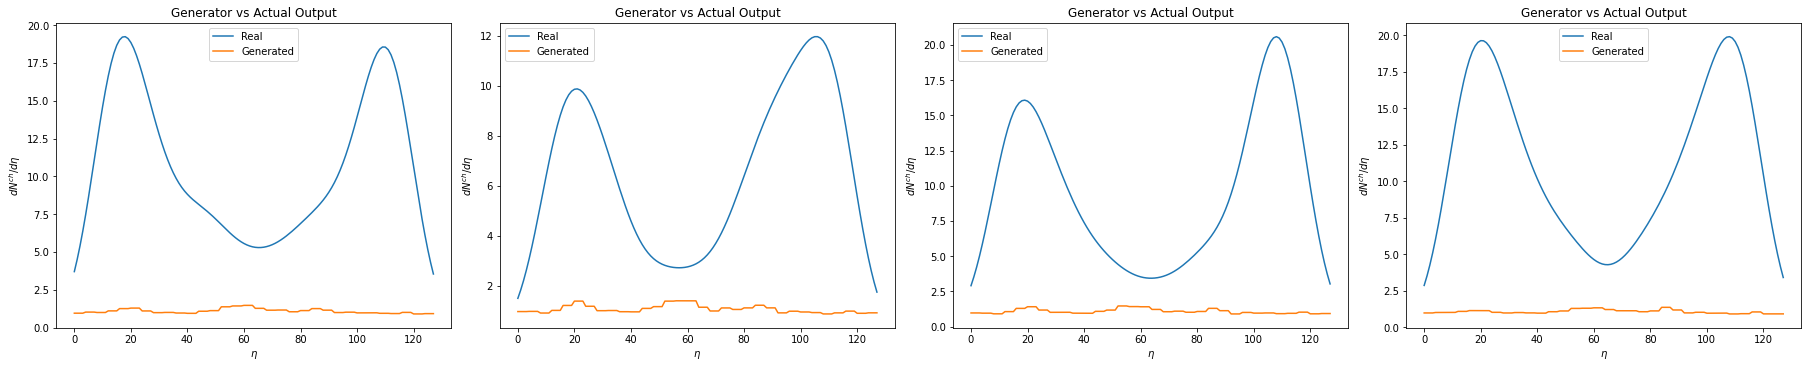

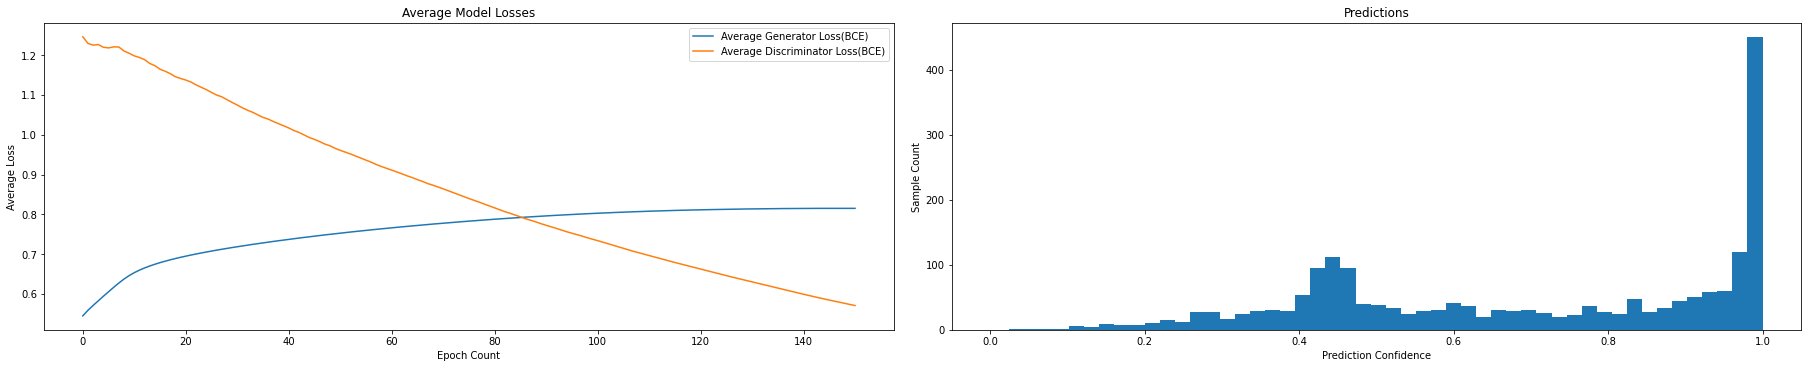

In [13]:
train(200)